# Bitcoin Price Prediction - Return-Based Model (FIXED)

**Key Fix:** Properly save model, scaler, and feature columns

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Data

In [26]:
# Load the 2-year dataset
df = pd.read_csv('../data/raw/bitcoin_2years_daily.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Data loaded: {df.shape}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"\nFirst few rows:")
display(df[['timestamp', 'open', 'high', 'low', 'close']].head())

Data loaded: (721, 14)
Date range: 2023-11-04 to 2025-10-24

First few rows:


,timestamp,open,high,low,close
0,2023-11-04,34741.2,35257.9,34614.4,35090.3
1,2023-11-05,35091.1,35382.1,34520.1,35050.0
2,2023-11-06,35050.1,35267.1,34767.3,35028.6
3,2023-11-07,35028.6,35900.1,34560.0,35449.0
4,2023-11-08,35449.1,36094.0,35100.0,35626.4


## 2. Create TARGET as Percentage Change!

In [27]:
# CRITICAL FIX: Predict tomorrow's RETURN, not absolute price!
df['high_next_day'] = df['high'].shift(-1)
df['target_return'] = (df['high_next_day'] - df['high']) / df['high']  # Percentage change!

print("✅ TARGET CREATED: Predicting PERCENTAGE CHANGE (return)")
print(f"\nTarget statistics:")
print(df['target_return'].describe())

print(f"\nExample:")
example = df[['timestamp', 'high', 'high_next_day', 'target_return']].head(10)
example['target_return_pct'] = example['target_return'] * 100
display(example)

print(f"\n💡 KEY INSIGHT: Returns are similar across all periods!")
print(f"   This solves the distribution shift problem.")

✅ TARGET CREATED: Predicting PERCENTAGE CHANGE (return)

Target statistics:
count    720.000000
mean       0.001836
std        0.021336
min       -0.074083
25%       -0.008593
50%        0.000226
75%        0.010390
max        0.111914
Name: target_return, dtype: float64

Example:


,timestamp,high,high_next_day,target_return,target_return_pct
0,2023-11-04,35257.9,35382.1,0.003523,0.352261
1,2023-11-05,35382.1,35267.1,-0.003250,-0.325023
2,2023-11-06,35267.1,35900.1,0.017949,1.794874
3,2023-11-07,35900.1,36094.0,0.005401,0.540110
4,2023-11-08,36094.0,37971.0,0.052003,5.200310
5,2023-11-09,37971.0,37500.0,-0.012404,-1.240420
6,2023-11-10,37500.0,37411.7,-0.002355,-0.235467
7,2023-11-11,37411.7,37227.6,-0.004921,-0.492092
8,2023-11-12,37227.6,37423.0,0.005249,0.524879
9,2023-11-13,37423.0,36750.1,-0.017981,-1.798092



💡 KEY INSIGHT: Returns are similar across all periods!
   This solves the distribution shift problem.


## 3. Create Features (Using Only Past Data)

In [28]:
# Create lag features
for lag in [1, 2, 3, 5, 7]:
    df[f'high_lag_{lag}'] = df['high'].shift(lag)
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'return_lag_{lag}'] = df['high'].pct_change(periods=lag)

# Moving averages
for window in [7, 14, 30]:
    df[f'sma_{window}'] = df['close'].rolling(window=window).mean()
    df[f'ema_{window}'] = df['close'].ewm(span=window, adjust=False).mean()
    df[f'std_{window}'] = df['close'].rolling(window=window).std()

# Price position (normalized)
df['price_to_sma_7'] = df['close'] / df['sma_7'] - 1
df['price_to_sma_30'] = df['close'] / df['sma_30'] - 1

# Volatility
df['volatility_7'] = df['close'].pct_change().rolling(7).std()
df['volatility_14'] = df['close'].pct_change().rolling(14).std()

# RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['rsi_14'] = calculate_rsi(df['close'], 14)

# Time features
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

print(f"✅ Features created: {len(df.columns)}")
print(f"\nFeatures:")
for col in df.columns:
    if col not in ['timestamp', 'name', 'timeOpen', 'timeClose', 'timeHigh', 'timeLow', 
                   'open', 'high', 'low', 'close', 'volume', 'marketCap', 
                   'high_next_day', 'target_return']:
        print(f"  - {col}")

✅ Features created: 47

Features:
  - daily_range
  - date
  - high_lag_1
  - close_lag_1
  - return_lag_1
  - high_lag_2
  - close_lag_2
  - return_lag_2
  - high_lag_3
  - close_lag_3
  - return_lag_3
  - high_lag_5
  - close_lag_5
  - return_lag_5
  - high_lag_7
  - close_lag_7
  - return_lag_7
  - sma_7
  - ema_7
  - std_7
  - sma_14
  - ema_14
  - std_14
  - sma_30
  - ema_30
  - std_30
  - price_to_sma_7
  - price_to_sma_30
  - volatility_7
  - volatility_14
  - rsi_14
  - day_of_week
  - month


## 4. Prepare Data

In [29]:
# Select features
feature_columns = [
    'high_lag_1', 'high_lag_2', 'high_lag_3', 'high_lag_5', 'high_lag_7',
    'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_5', 'close_lag_7',
    'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5', 'return_lag_7',
    'sma_7', 'sma_14', 'sma_30',
    'ema_7', 'ema_14', 'ema_30',
    'std_7', 'std_14', 'std_30',
    'price_to_sma_7', 'price_to_sma_30',
    'volatility_7', 'volatility_14',
    'rsi_14',
    'day_of_week', 'month'
]

# Remove rows with NaN
df_clean = df.dropna(subset=['target_return'] + feature_columns).copy()

X = df_clean[feature_columns].copy()
y = df_clean['target_return'].copy()  # Predicting RETURN!
timestamps = df_clean['timestamp'].copy()
current_highs = df_clean['high'].copy()  # Need this to convert back to price!

print(f"Data shape after cleaning: {X.shape}")
print(f"Features: {len(feature_columns)}")
print(f"Target: Percentage return (not absolute price!)")

Data shape after cleaning: (691, 31)
Features: 31
Target: Percentage return (not absolute price!)


## 5. Train/Val/Test Split

In [30]:
n_samples = len(X)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
timestamps_train = timestamps.iloc[:train_size]
highs_train = current_highs.iloc[:train_size]

X_val = X.iloc[train_size:train_size+val_size]
y_val = y.iloc[train_size:train_size+val_size]
timestamps_val = timestamps.iloc[train_size:train_size+val_size]
highs_val = current_highs.iloc[train_size:train_size+val_size]

X_test = X.iloc[train_size+val_size:]
y_test = y.iloc[train_size+val_size:]
timestamps_test = timestamps.iloc[train_size+val_size:]
highs_test = current_highs.iloc[train_size+val_size:]

print("DATA SPLIT:")
print(f"Train: {len(X_train)} | {timestamps_train.min().date()} to {timestamps_train.max().date()}")
print(f"Val:   {len(X_val)} | {timestamps_val.min().date()} to {timestamps_val.max().date()}")
print(f"Test:  {len(X_test)} | {timestamps_test.min().date()} to {timestamps_test.max().date()}")

print(f"\n✅ KEY: Target is RETURNS (should be similar across sets)")
print(f"  Train returns: mean={y_train.mean():.4f}, std={y_train.std():.4f}")
print(f"  Val returns:   mean={y_val.mean():.4f}, std={y_val.std():.4f}")
print(f"  Test returns:  mean={y_test.mean():.4f}, std={y_test.std():.4f}")
print(f"\n💡 Much more similar than absolute prices!")

DATA SPLIT:
Train: 483 | 2023-12-03 to 2025-03-29
Val:   103 | 2025-03-30 to 2025-07-10
Test:  105 | 2025-07-11 to 2025-10-23

✅ KEY: Target is RETURNS (should be similar across sets)
  Train returns: mean=0.0018, std=0.0232
  Val returns:   mean=0.0036, std=0.0176
  Test returns:  mean=-0.0004, std=0.0163

💡 Much more similar than absolute prices!


## 6. Scale Features

In [31]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("✓ Features scaled")

✓ Features scaled


## 7. Train Model

In [32]:
print("="*70)
print("TRAINING RETURN-BASED MODEL")
print("="*70)

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

print("Training model to predict RETURNS...")
model.fit(X_train_scaled, y_train)

# Predict RETURNS
y_train_pred_return = model.predict(X_train_scaled)
y_val_pred_return = model.predict(X_val_scaled)
y_test_pred_return = model.predict(X_test_scaled)

# Convert returns back to PRICES!
y_train_pred_price = highs_train.values * (1 + y_train_pred_return)
y_val_pred_price = highs_val.values * (1 + y_val_pred_return)
y_test_pred_price = highs_test.values * (1 + y_test_pred_return)

# Actual prices (for comparison)
y_train_actual_price = highs_train.values * (1 + y_train.values)
y_val_actual_price = highs_val.values * (1 + y_val.values)
y_test_actual_price = highs_test.values * (1 + y_test.values)

print("\n✓ Model trained!")
print("✓ Returns converted back to prices for evaluation")

TRAINING RETURN-BASED MODEL
Training model to predict RETURNS...

✓ Model trained!
✓ Returns converted back to prices for evaluation

✓ Model trained!
✓ Returns converted back to prices for evaluation


## 8. Evaluate Model

In [33]:
def evaluate_model(y_true, y_pred, set_name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{set_name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

print("="*70)
print("MODEL RESULTS (PRICE-BASED METRICS)")
print("="*70)

train_metrics = evaluate_model(y_train_actual_price, y_train_pred_price, "Train")
val_metrics = evaluate_model(y_val_actual_price, y_val_pred_price, "Validation")
test_metrics = evaluate_model(y_test_actual_price, y_test_pred_price, "Test")

print("\n" + "="*70)
print("SUCCESS CHECK")
print("="*70)

if test_metrics['r2'] > 0.75:
    print("\n🎉 EXCELLENT! Test R² > 0.75")
elif test_metrics['r2'] > 0.60:
    print("\n✅ GOOD! Test R² > 0.60")
elif test_metrics['r2'] > 0:
    print("\n✅ SUCCESS! Test R² is positive!")
else:
    print("\n⚠️ Still negative, but should be much better than before")

# Check overfitting
r2_gap = train_metrics['r2'] - test_metrics['r2']
print(f"\nOverfitting check:")
print(f"  Train-Test R² gap: {r2_gap:.4f}")
if r2_gap < 0.15:
    print("  ✅ Minimal overfitting!")
elif r2_gap < 0.30:
    print("  ⚠️ Moderate overfitting")
else:
    print("  ⚠️ High overfitting")

MODEL RESULTS (PRICE-BASED METRICS)

Train:
  RMSE: $1,305.44
  MAE:  $904.83
  R²:   0.9950
  MAPE: 1.28%

Validation:
  RMSE: $1,655.58
  MAE:  $1,170.89
  R²:   0.9710
  MAPE: 1.17%

Test:
  RMSE: $1,785.70
  MAE:  $1,317.77
  R²:   0.8150
  MAPE: 1.14%

SUCCESS CHECK

🎉 EXCELLENT! Test R² > 0.75

Overfitting check:
  Train-Test R² gap: 0.1800
  ⚠️ Moderate overfitting


## 9. Visualize Results

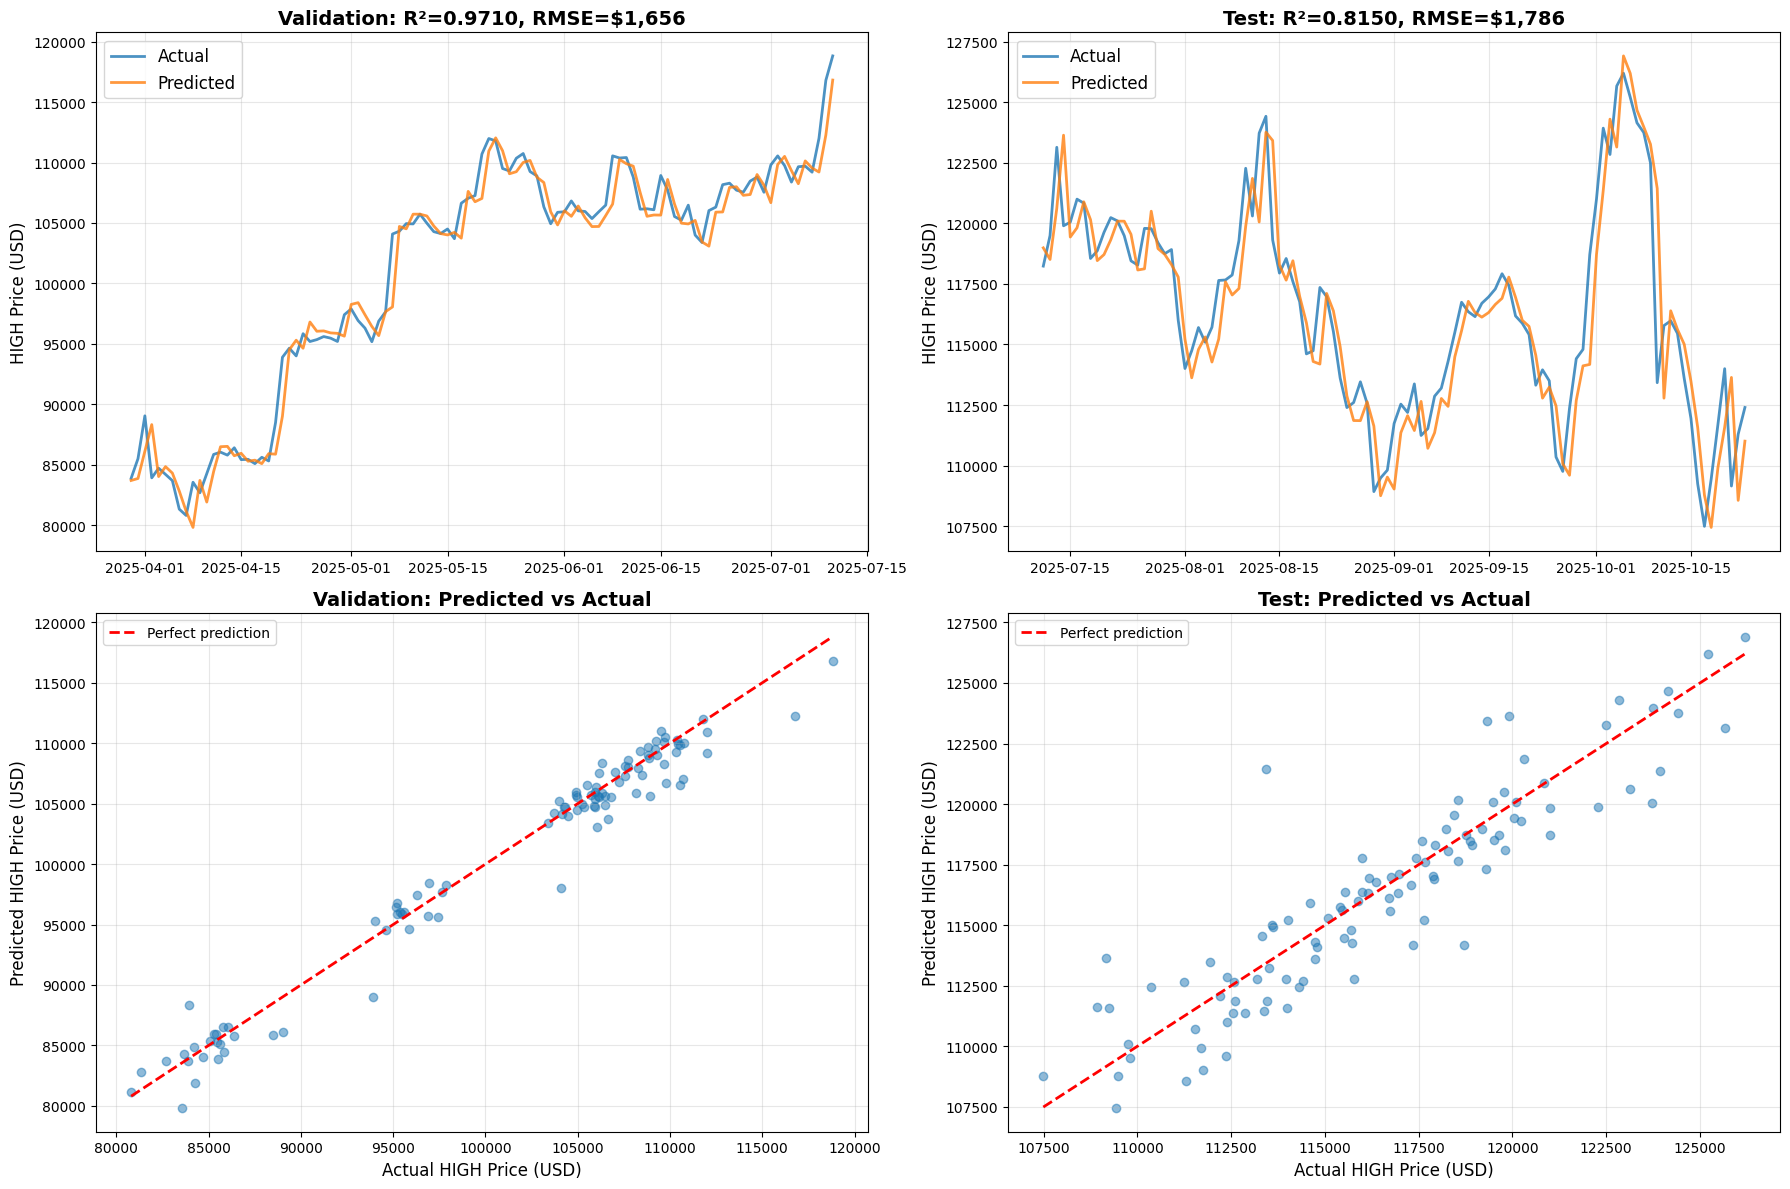


✓ Predictions should now FOLLOW the actual prices (not flat!)


In [34]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Validation predictions
axes[0, 0].plot(timestamps_val, y_val_actual_price, label='Actual', linewidth=2, alpha=0.8)
axes[0, 0].plot(timestamps_val, y_val_pred_price, label='Predicted', linewidth=2, alpha=0.8)
axes[0, 0].set_title(f'Validation: R²={val_metrics["r2"]:.4f}, RMSE=${val_metrics["rmse"]:,.0f}', 
                     fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('HIGH Price (USD)', fontsize=12)
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Test predictions
axes[0, 1].plot(timestamps_test, y_test_actual_price, label='Actual', linewidth=2, alpha=0.8)
axes[0, 1].plot(timestamps_test, y_test_pred_price, label='Predicted', linewidth=2, alpha=0.8)
axes[0, 1].set_title(f'Test: R²={test_metrics["r2"]:.4f}, RMSE=${test_metrics["rmse"]:,.0f}', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('HIGH Price (USD)', fontsize=12)
axes[0, 1].legend(fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot - Validation
axes[1, 0].scatter(y_val_actual_price, y_val_pred_price, alpha=0.5)
axes[1, 0].plot([y_val_actual_price.min(), y_val_actual_price.max()], 
                [y_val_actual_price.min(), y_val_actual_price.max()], 
                'r--', linewidth=2, label='Perfect prediction')
axes[1, 0].set_xlabel('Actual HIGH Price (USD)', fontsize=12)
axes[1, 0].set_ylabel('Predicted HIGH Price (USD)', fontsize=12)
axes[1, 0].set_title('Validation: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot - Test
axes[1, 1].scatter(y_test_actual_price, y_test_pred_price, alpha=0.5)
axes[1, 1].plot([y_test_actual_price.min(), y_test_actual_price.max()], 
                [y_test_actual_price.min(), y_test_actual_price.max()], 
                'r--', linewidth=2, label='Perfect prediction')
axes[1, 1].set_xlabel('Actual HIGH Price (USD)', fontsize=12)
axes[1, 1].set_ylabel('Predicted HIGH Price (USD)', fontsize=12)
axes[1, 1].set_title('Test: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Predictions should now FOLLOW the actual prices (not flat!)")

## 10. Save Model (FIXED)

In [35]:
import os

os.makedirs('../models', exist_ok=True)

print("="*70)
print("SAVING MODEL FILES")
print("="*70)

# Verify objects before saving
print(f"\n1. Model type: {type(model)}")
print(f"   Expected: RandomForestRegressor")
print(f"   ✓ Correct: {type(model).__name__ == 'RandomForestRegressor'}")

print(f"\n2. Scaler type: {type(scaler)}")
print(f"   Expected: RobustScaler")
print(f"   ✓ Correct: {type(scaler).__name__ == 'RobustScaler'}")

print(f"\n3. Feature columns type: {type(feature_columns)}")
print(f"   Expected: list")
print(f"   Count: {len(feature_columns)} features")
print(f"   ✓ Correct: {isinstance(feature_columns, list)}")

# CRITICAL FIX: Save in correct order!
print("\n" + "="*70)
print("Saving files...")

# Save model (RandomForestRegressor object)
joblib.dump(model, '../models/bitcoin_return_model.pkl')
print("✓ Saved: bitcoin_return_model.pkl (RandomForestRegressor)")

# Save scaler (RobustScaler object)
joblib.dump(scaler, '../models/bitcoin_scaler_return.pkl')
print("✓ Saved: bitcoin_scaler_return.pkl (RobustScaler)")

# Save feature columns (list)
joblib.dump(feature_columns, '../models/feature_columns_return.pkl')
print("✓ Saved: feature_columns_return.pkl (list of 31 features)")

# Save metadata
metadata = {
    'algorithm': 'RandomForest',
    'prediction_type': 'returns',  # CRITICAL!
    'n_features': len(feature_columns),
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_r2': test_metrics['r2'],
    'test_rmse': test_metrics['rmse'],
    'feature_list': feature_columns,
    'usage_note': 'Model predicts percentage return. To get price: predicted_high = current_high * (1 + predicted_return)'
}
joblib.dump(metadata, '../models/model_metadata_return.pkl')
print("✓ Saved: model_metadata_return.pkl")

print("\n" + "="*70)
print("VERIFICATION: Loading saved files to confirm")
print("="*70)

# Verify files were saved correctly
loaded_model = joblib.load('../models/bitcoin_return_model.pkl')
loaded_scaler = joblib.load('../models/bitcoin_scaler_return.pkl')
loaded_features = joblib.load('../models/feature_columns_return.pkl')
loaded_metadata = joblib.load('../models/model_metadata_return.pkl')

print(f"\n1. Model: {type(loaded_model).__name__}")
if type(loaded_model).__name__ == 'RandomForestRegressor':
    print("   ✅ CORRECT: RandomForestRegressor loaded")
else:
    print(f"   ❌ ERROR: Expected RandomForestRegressor, got {type(loaded_model)}")

print(f"\n2. Scaler: {type(loaded_scaler).__name__}")
if type(loaded_scaler).__name__ == 'RobustScaler':
    print("   ✅ CORRECT: RobustScaler loaded")
else:
    print(f"   ❌ ERROR: Expected RobustScaler, got {type(loaded_scaler)}")

print(f"\n3. Features: {type(loaded_features).__name__} with {len(loaded_features)} items")
if isinstance(loaded_features, list) and len(loaded_features) == 31:
    print("   ✅ CORRECT: Feature list loaded")
else:
    print(f"   ❌ ERROR: Expected list of 31 features")

print(f"\n4. Metadata: {type(loaded_metadata).__name__}")
print(f"   Algorithm: {loaded_metadata.get('algorithm')}")
print(f"   Prediction type: {loaded_metadata.get('prediction_type')}")
print(f"   Test R²: {loaded_metadata.get('test_r2'):.4f}")

print("\n" + "="*70)
print("✅ ALL FILES SAVED CORRECTLY!")
print("="*70)
print(f"\nTest Performance:")
print(f"  R²:   {test_metrics['r2']:.4f}")
print(f"  RMSE: ${test_metrics['rmse']:,.2f}")
print(f"  MAE:  ${test_metrics['mae']:,.2f}")
print(f"\n⚠️  USAGE NOTE:")
print(f"  This model predicts RETURNS (percentage change)")
print(f"  To get tomorrow's price:")
print(f"    predicted_return = model.predict(X)[0]")
print(f"    predicted_high = current_high * (1 + predicted_return)")

SAVING MODEL FILES

1. Model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
   Expected: RandomForestRegressor
   ✓ Correct: True

2. Scaler type: <class 'sklearn.preprocessing._data.RobustScaler'>
   Expected: RobustScaler
   ✓ Correct: True

3. Feature columns type: <class 'list'>
   Expected: list
   Count: 31 features
   ✓ Correct: True

Saving files...
✓ Saved: bitcoin_return_model.pkl (RandomForestRegressor)
✓ Saved: bitcoin_scaler_return.pkl (RobustScaler)
✓ Saved: feature_columns_return.pkl (list of 31 features)
✓ Saved: model_metadata_return.pkl

VERIFICATION: Loading saved files to confirm

1. Model: RandomForestRegressor
   ✅ CORRECT: RandomForestRegressor loaded

2. Scaler: RobustScaler
   ✅ CORRECT: RobustScaler loaded

3. Features: list with 31 items
   ✅ CORRECT: Feature list loaded

4. Metadata: dict
   Algorithm: RandomForest
   Prediction type: returns
   Test R²: 0.8150

✅ ALL FILES SAVED CORRECTLY!

Test Performance:
  R²:   0.8150
  RMSE: $1,785.70


## 11. Test Prediction (Example)

In [36]:
print("="*70)
print("EXAMPLE PREDICTION")
print("="*70)

# Use the last test sample
example_features = X_test_scaled.iloc[-1:].values
example_current_high = highs_test.iloc[-1]
example_actual_high_next = y_test_actual_price[-1]

# Predict return
predicted_return = loaded_model.predict(example_features)[0]

# Convert to price
predicted_high_price = example_current_high * (1 + predicted_return)

print(f"\nCurrent HIGH price: ${example_current_high:,.2f}")
print(f"Predicted return:   {predicted_return:.4%}")
print(f"Predicted HIGH:     ${predicted_high_price:,.2f}")
print(f"Actual HIGH:        ${example_actual_high_next:,.2f}")
print(f"Error:              ${abs(predicted_high_price - example_actual_high_next):,.2f}")
print(f"\n✓ This is how the API should use the model!")

EXAMPLE PREDICTION

Current HIGH price: $111,296.00
Predicted return:   -0.2574%
Predicted HIGH:     $111,009.50
Actual HIGH:        $112,400.00
Error:              $1,390.50

✓ This is how the API should use the model!
